Postavljanje okruženja

In [1]:
!pip install keras tensorflow
!pip install pandas openpyxl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib.dates import DateFormatter, AutoDateLocator
import matplotlib.dates as mdates
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Diplomski/diplomski/datasets/google/GOOG_fund_data.csv'

Mounted at /content/drive


Postavljanje dataseta:

* Dataset sadržava vrijednosti za svaki radni dan burze od 2015 do 2020
* Svaki redak sadržava datum i cijenu dionice na taj datum
* Svaki redak također sadržava cijenu dionice i ostale vrijednosti od prošlog radnog dana

In [2]:
data = pd.read_csv(file_path)

features_to_shift = [
  "Adj_Close","Revenue","Net_Income","EPS","Gross_Profit_Margin",
  "Operating_Margin","Net_Profit_Margin","Cash_Flow_From_Operations",
  "Total_Assets","Total_Liabilites","Shareholders_Equity"
]

data['today_price'] = data['Adj_Close']
data[features_to_shift] = data[features_to_shift].shift(1)

data['prediction'] = data['today_price'] -  data['Adj_Close']

data['price_diff'] = data['prediction'].shift(1)

features_to_keep = [
  "Date","Adj_Close","Revenue","Net_Income","EPS","Gross_Profit_Margin",
  "Operating_Margin","Net_Profit_Margin","Cash_Flow_From_Operations",
  "Total_Assets","Total_Liabilites","Shareholders_Equity", "today_price", "price_diff", 'prediction'
]

data = data[features_to_keep]
data.dropna(inplace=True)

<ipython-input-2-08f38d020483>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Parametri koji će se koristiti kao input (X) varijabla za model:
* Lako možemo promijeniti ulazne varijable

In [3]:
indicators_to_keep = [
"Adj_Close","Revenue","Net_Income","EPS","Gross_Profit_Margin",
  "Operating_Margin","Net_Profit_Margin","Cash_Flow_From_Operations",
  "Total_Assets","Total_Liabilites","Shareholders_Equity", "price_diff"
]

In [4]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [5]:
train_size = int(len(data) * 0.8)

Postavljanje modela i predviđanje cijene:

*   Dataset dijelimo na train(80%) i test(20%)
*   Pomoću scaler skaliramo sve vrijednosti
* Moramo reshapeat X vrijednosti kako bi LSTM model mogao primiti te podatke
* Model koristi optimizer funkciju "adam"
* Model sadržava ulazni sloj koji ima 1000 neurona (units), dropout sloj, jedan skriveni sloj koji ima 1000 neurona, još jedan dropout sloj, te jedan izlazni neuron
* Pomoću model.predict predviđamo vrijednost dionice

In [6]:
def walk_forward_validation(data):
    actual_values = []
    predicted_values = []
    rmse_values = []
    for i in range(train_size, len(data)):
        train_data = data.iloc[:i+1]
        train_data = train_data[indicators_to_keep]

        for column in train_data.columns:
          scaler_x = MinMaxScaler()
          train_data[column] = scaler_x.fit_transform(train_data[[column]])

        test_data = train_data.tail(1)
        train_data = train_data.iloc[:i]

        X_train = train_data
        y_train = data.iloc[:i]["prediction"]
        X_test = test_data
        y_test = data.iloc[i:i+1]["prediction"]

        X_train = X_train.values
        X_test = X_test.values

        X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
        X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

        scaler_y = MinMaxScaler()

        y_train = scaler_y.fit_transform(np.array(y_train).reshape(-1,1))
        y_test = np.array(y_test).reshape(-1,1)

        lstm_model = Sequential([
            LSTM(units=100, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
            Dropout(0.2),
            LSTM(units=100),
            Dropout(0.2),
            Dense(units=1)
        ])

        lstm_model.compile(optimizer='adam', loss='mean_squared_error')

        lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=64, validation_split=0.1, verbose=0, callbacks=[early_stopping])

        prediction = lstm_model.predict(X_test_lstm)
        prediction = scaler_y.inverse_transform(prediction)

        actual_values.append(y_test)
        predicted_values.append(prediction)
        value = mean_squared_error(y_test, prediction)
        value = np.sqrt(value)
        rmse_values.append(value)

    return predicted_values, actual_values, rmse_values

predicted_values, actual_values, rmse_values =  walk_forward_validation(data)

1/1 [==============================] - 1s 795ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 847ms/step


<ipython-input-6-8e151cef6f86>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = scaler_x.fit_transform(train_data[[column]])
<ipython-input-6-8e151cef6f86>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = scaler_x.fit_transform(train_data[[column]])
<ipython-input-6-8e151cef6f86>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

1/1 [==============================] - 1s 852ms/step


Grafički prikaz

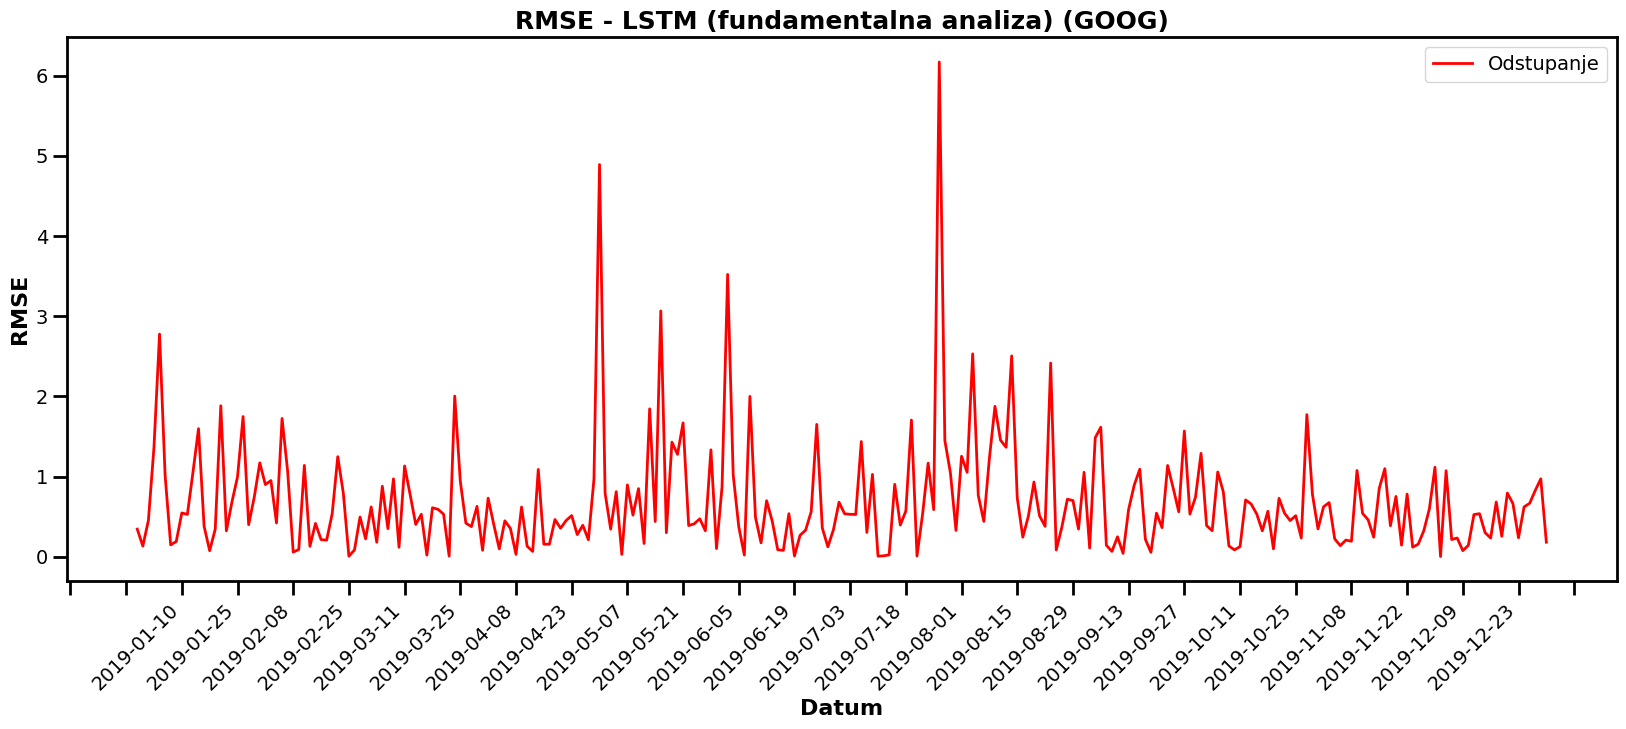

In [7]:
plot_data = data.copy()
plot_data = plot_data.iloc[train_size:]

plt.figure(figsize=(20, 8))
plt.plot(plot_data["Date"], rmse_values, label='Odstupanje', color='red', linewidth=2)  # Increase line width

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('RMSE', fontsize=16, fontweight='bold')
plt.title('RMSE - LSTM (fundamentalna analiza) (GOOG)', fontsize=18, fontweight='bold')

# Customize the legend to make the label "Odstupanje" fatter
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()


In [8]:
excel = {
    'Date': plot_data["Date"],
    'RMSE': rmse_values
}
df = pd.DataFrame(excel)

# Export to an Excel file
excel_file_path = 'LSTM_fund_GOOG_rmse_values.xlsx'
df.to_excel(excel_file_path, index=False)

In [9]:
predicted_values = np.concatenate(predicted_values).flatten()
actual_values = np.concatenate(actual_values).flatten()

In [10]:

mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
print(rmse)

0.9914870668666678


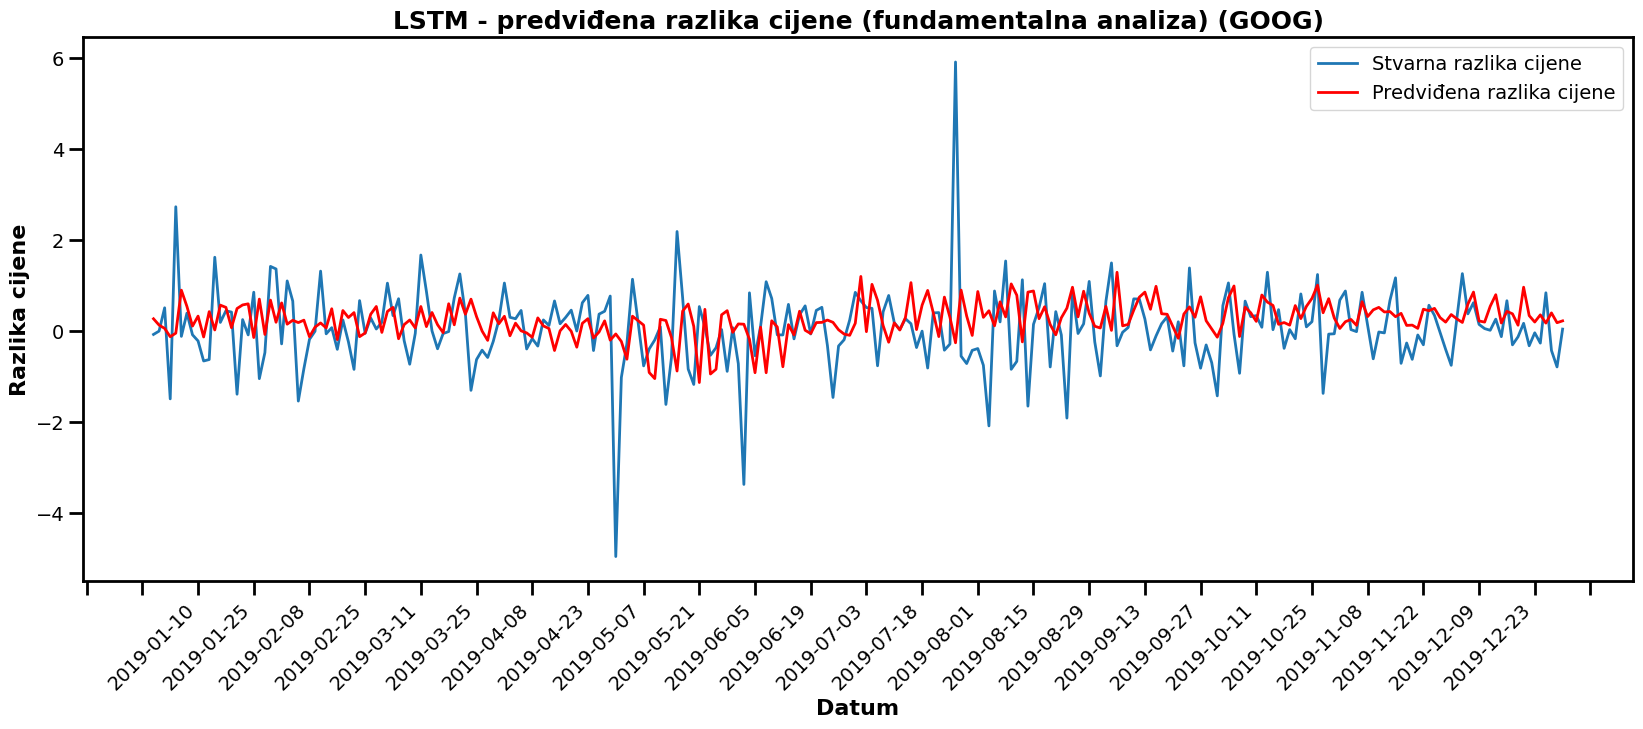

In [11]:


plot_data = data.copy()
plot_data = plot_data.iloc[train_size:]

plt.figure(figsize=(20, 8))

# Plot the actual and predicted values with increased line width
plt.plot(plot_data["Date"], actual_values, label='Stvarna razlika cijene', linewidth=2)  # Thicker line
plt.plot(plot_data["Date"], predicted_values, label='Predviđena razlika cijene', color='red', linewidth=2)  # Thicker line

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('Razlika cijene', fontsize=16, fontweight='bold')
plt.title('LSTM - predviđena razlika cijene (fundamentalna analiza) (GOOG)', fontsize=18, fontweight='bold')

# Customize the legend to make the labels fatter and more prominent
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()


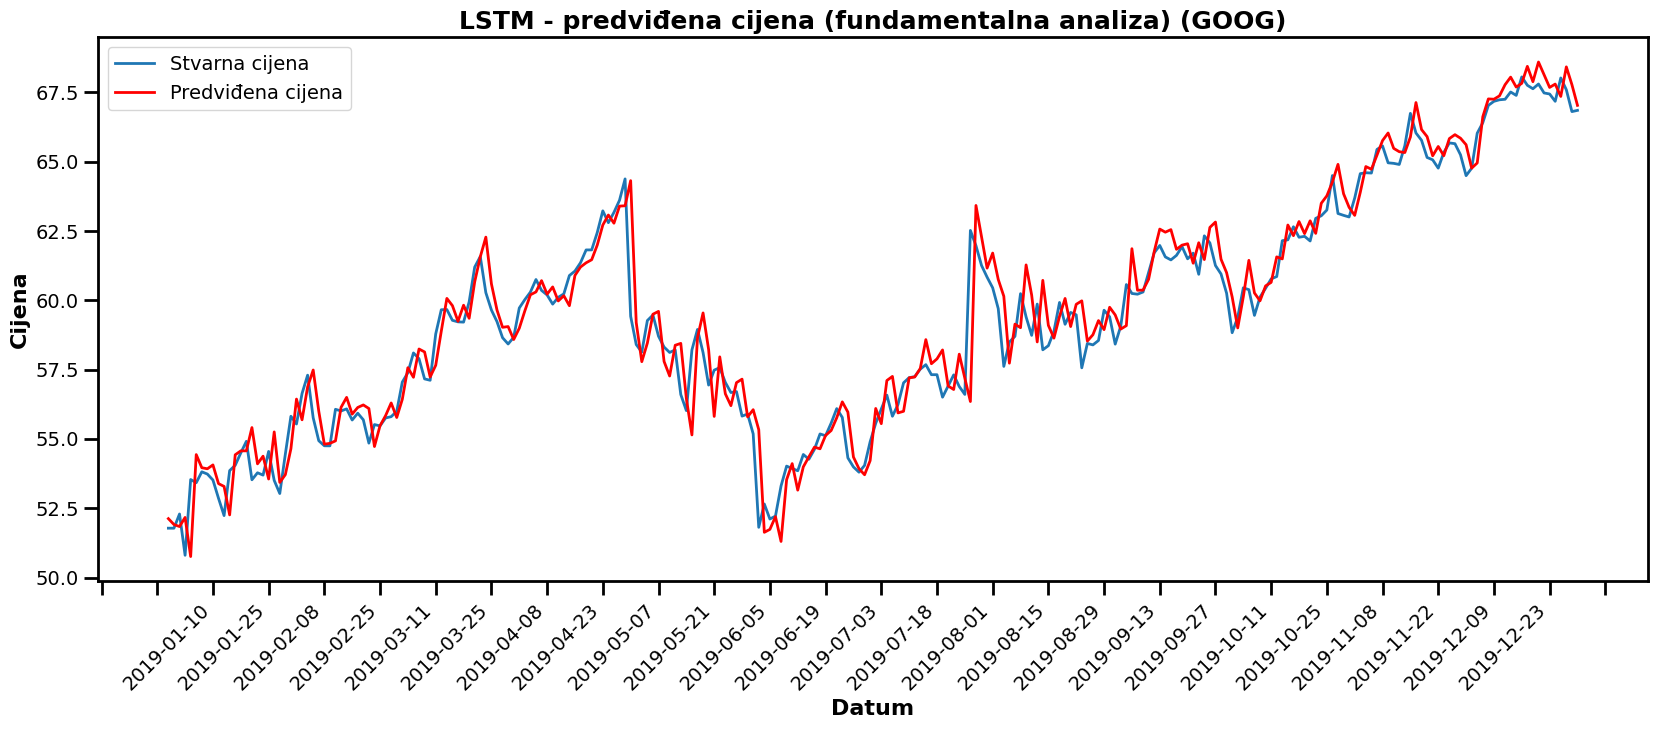

In [12]:
plot_data = data.copy()
plot_data = plot_data.iloc[train_size:]

plot_data["predicted_diff"] = predicted_values
plot_data["Predicted_price"] = plot_data["Adj_Close"] + plot_data["predicted_diff"]

plt.figure(figsize=(20, 8))

# Plot actual and predicted prices with increased line thickness
plt.plot(plot_data["Date"], plot_data["today_price"], label='Stvarna cijena', linewidth=2)  # Thicker line
plt.plot(plot_data["Date"], plot_data["Predicted_price"], label='Predviđena cijena', color='red', linewidth=2)  # Thicker line

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('Cijena', fontsize=16, fontweight='bold')
plt.title('LSTM - predviđena cijena (fundamentalna analiza) (GOOG)', fontsize=18, fontweight='bold')

# Customize the legend to make the labels fatter and more prominent
plt.legend(fontsize=14, loc='best', frameon=True)

# Calculate and print MSE and RMSE
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)

plt.show()
